(bivariate-growth-mod-notebook)=
# Modelli di crescita latenti bivariati

I processi di sviluppo raramente si verificano in modo isolato. Di conseguenza, i ricercatori spesso vogliono studiare più di un costrutto nel tempo per comprendere il loro sviluppo congiunto e come i costrutti e i loro cambiamenti siano correlati nel tempo. Sono stati proposti diversi modelli statistici per studiare contemporaneamente il cambiamento in più entità e in questo capitolo ne copriamo due. Il primo, chiamato modello di crescita multivariato (MGM; noto anche come processo parallelo e modello di crescita correlato; McArdle, 1988), esamina le interrelazioni tra due processi di crescita distinti. Il secondo, chiamato modello di crescita con covariata variabile nel tempo (TVC), stima l’effetto che una variabile che cambia nel tempo ha sui punteggi mentre modella contemporaneamente il cambiamento in quei punteggi con un modello di crescita. La variabile che cambia nel tempo è spesso definita come un predittore dinamico perché il suo valore cambia nel tempo. Questi modelli sono comuni nella ricerca sullo sviluppo e rispondono a domande specifiche riguardo le associazioni tra due o più entità che cambiano simultaneamente così come le associazioni tra i cambiamenti per individui correlati (ad esempio, mariti e mogli).

Carichiamo i pacchetti necessari.

In [1]:
source("_common.R")
suppressPackageStartupMessages({
    library("lavaan")
    library("semPlot")
    library("knitr")
    library("markdown")
    library("patchwork")
    library("psych")
    library("DT")
    library("kableExtra")
    library("lme4")
})

set.seed(12345)

Questo tutorial mostra come adattare modelli di crescita lineare multivariati (bivariati) nel framework SEM in R. I dati sono tratti dal Capitolo 8 {cite:t}`grimm2016growth`. In particolare, utilizzando il set di dati NLSY-CYA, esaminiamo come le differenze individuali nella variazione del rendimento in matematica dei bambini durante la scuola siano correlate alle differenze individuali nella variazione dell’iperattività dei bambini (valutata dagli insegnanti). Iniziamo a leggere i dati.

In [2]:
# set filepath for data file
filepath <- "https://raw.githubusercontent.com/LRI-2/Data/main/GrowthModeling/nlsy_math_hyp_long_R.dat"
# read in the text data file using the url() function
dat <- read.table(
  file = url(filepath),
  na.strings = "."
) # indicates the missing data designator
# copy data with new name
nlsy_math_hyp_long <- dat

# Add names the columns of the data set
names(nlsy_math_hyp_long) <- c(
  "id", "female", "lb_wght", "anti_k1",
  "math", "comp", "rec", "bpi", "as", "anx", "hd",
  "hyp", "dp", "wd",
  "grade", "occ", "age", "men", "spring", "anti"
)

# reducing to variables of interest
nlsy_math_hyp_long <- nlsy_math_hyp_long[, c("id", "grade", "math", "hyp")]

# view the first few observations in the data set
head(nlsy_math_hyp_long, 10)

,id,grade,math,hyp
,<int>,<int>,<int>,<int>
1,201,3,38,0
2,201,5,55,0
3,303,2,26,1
4,303,5,33,1
5,2702,2,56,2
6,2702,4,58,3
7,2702,8,80,3
8,4303,3,41,1
9,4303,4,58,1


Il nostro interesse specifico è il cambiamento intra-individuale nelle misure ripetute di matematica e iperattività durante il periodo scolastico (`grade`).

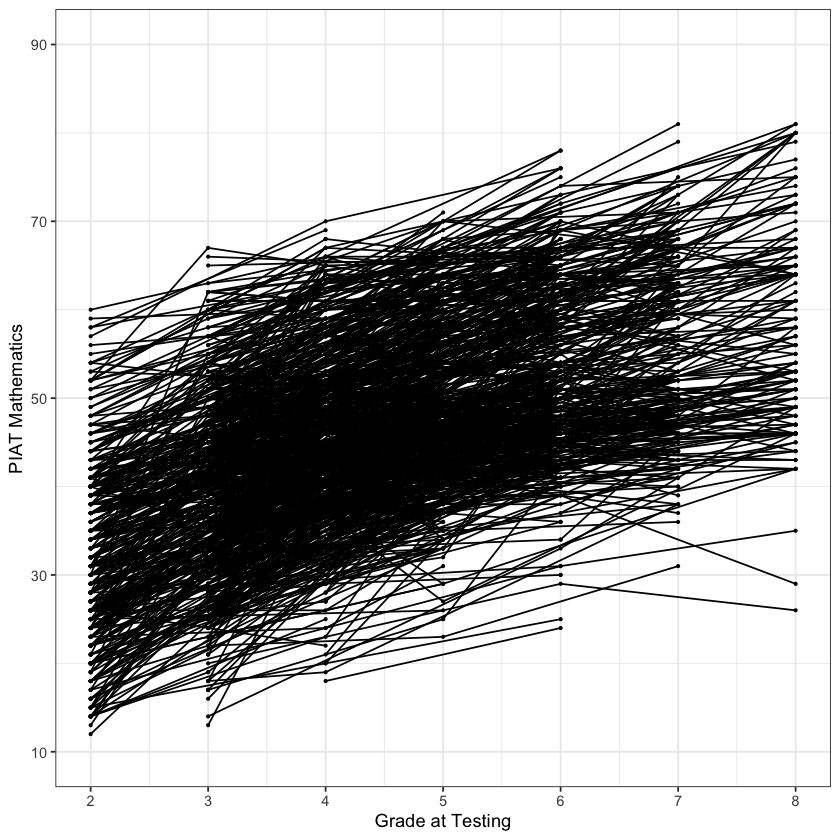

In [3]:
# intraindividual change trajetories
ggplot(
  data = nlsy_math_hyp_long, # data set
  aes(x = grade, y = math, group = id)
) + # setting variables
  geom_point(size = .5) + # adding points to plot
  geom_line() + # adding lines to plot
  theme_bw() + # changing style/background
  # setting the x-axis with breaks and labels
  scale_x_continuous(
    limits = c(2, 8),
    breaks = c(2, 3, 4, 5, 6, 7, 8),
    name = "Grade at Testing"
  ) +
  # setting the y-axis with limits breaks and labels
  scale_y_continuous(
    limits = c(10, 90),
    breaks = c(10, 30, 50, 70, 90),
    name = "PIAT Mathematics"
  )

Esaminiamo i punteggi di iperattività in funzione di `grade`.

Warning message:
“Removed 51 rows containing missing values (`geom_point()`).”


Warning message:
“Removed 44 rows containing missing values (`geom_line()`).”


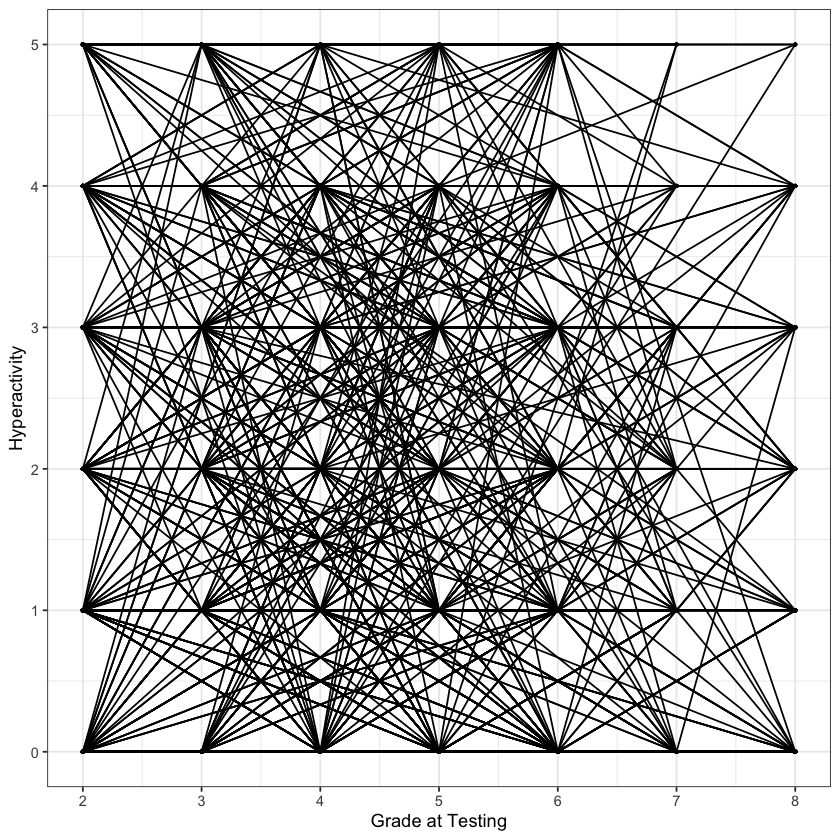

In [4]:
# intraindividual change trajetories
ggplot(
  data = nlsy_math_hyp_long, # data set
  aes(x = grade, y = hyp, group = id)
) + # setting variables
  geom_point(size = .5) + # adding points to plot
  geom_line() + # adding lines to plot
  theme_bw() + # changing style/background
  # setting the x-axis with breaks and labels
  scale_x_continuous(
    limits = c(2, 8),
    breaks = c(2, 3, 4, 5, 6, 7, 8),
    name = "Grade at Testing"
  ) +
  # setting the y-axis with limits breaks and labels
  scale_y_continuous(
    limits = c(0, 5),
    breaks = c(0, 1, 2, 3, 4, 5),
    name = "Hyperactivity"
  )

Per semplicità, leggiamo i dati in formato long da file.

In [5]:
# set filepath for data file
filepath <- "https://raw.githubusercontent.com/LRI-2/Data/main/GrowthModeling/nlsy_math_hyp_wide_R.dat"
# read in the text data file using the url() function
dat <- read.table(
  file = url(filepath),
  na.strings = "."
) # indicates the missing data designator
# copy data with new name
nlsy_math_hyp_wide <- dat

# Add names the columns of the data set
# Give the variable names
names(nlsy_math_hyp_wide) <- c(
  "id", "female", "lb_wght", "anti_k1",
  "math2", "math3", "math4", "math5", "math6", "math7", "math8",
  "comp2", "comp3", "comp4", "comp5", "comp6", "comp7", "comp8",
  "rec2", "rec3", "rec4", "rec5", "rec6", "rec7", "rec8",
  "bpi2", "bpi3", "bpi4", "bpi5", "bpi6", "bpi7", "bpi8",
  "asl2", "asl3", "asl4", "asl5", "asl6", "asl7", "asl8",
  "ax2", "ax3", "ax4", "ax5", "ax6", "ax7", "ax8",
  "hds2", "hds3", "hds4", "hds5", "hds6", "hds7", "hds8",
  "hyp2", "hyp3", "hyp4", "hyp5", "hyp6", "hyp7", "hyp8",
  "dpn2", "dpn3", "dpn4", "dpn5", "dpn6", "dpn7", "dpn8",
  "wdn2", "wdn3", "wdn4", "wdn5", "wdn6", "wdn7", "wdn8",
  "age2", "age3", "age4", "age5", "age6", "age7", "age8",
  "men2", "men3", "men4", "men5", "men6", "men7", "men8",
  "spring2", "spring3", "spring4", "spring5", "spring6", "spring7", "spring8",
  "anti2", "anti3", "anti4", "anti5", "anti6", "anti7", "anti8"
)

# reducing to variables of interest
nlsy_multi_wide <- nlsy_math_hyp_wide[, c(
  "id",
  "math2", "math3", "math4", "math5", "math6", "math7", "math8",
  "hyp2", "hyp3", "hyp4", "hyp5", "hyp6", "hyp7", "hyp8"
)]

# view the first few observations in the data set
head(nlsy_multi_wide, 10)

,id,math2,math3,math4,math5,math6,math7,math8,hyp2,hyp3,hyp4,hyp5,hyp6,hyp7,hyp8
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,201,NA,38,NA,55,NA,NA,NA,NA,0,NA,0,NA,NA,NA
2,303,26,NA,NA,33,NA,NA,NA,1,NA,NA,1,NA,NA,NA
3,2702,56,NA,58,NA,NA,NA,80,2,NA,3,NA,NA,NA,3
4,4303,NA,41,58,NA,NA,NA,NA,NA,1,1,NA,NA,NA,NA
5,5002,NA,NA,46,NA,54,NA,66,NA,NA,3,NA,2,NA,3
6,5005,35,NA,50,NA,60,NA,59,0,NA,3,NA,0,NA,1
7,5701,NA,62,61,NA,NA,NA,NA,NA,4,3,NA,NA,NA,NA
8,6102,NA,NA,55,67,NA,81,NA,NA,NA,2,0,NA,0,NA
9,6801,NA,54,NA,62,NA,66,NA,NA,0,NA,1,NA,1,NA


Per l’implementazione SEM, utilizziamo i punteggi di rendimento in matematica e iperattività e le covariate invarianti nel tempo dai dati Wide. Specifichiamo un modello di crescita lineare bivariato usando la sintassi lavaan.

In [6]:
# writing out linear growth model in full SEM way
bivariate_lavaan_model <- "
  # latent variable definitions
      #intercept for math
      eta_1 =~ 1*math2
      eta_1 =~ 1*math3
      eta_1 =~ 1*math4
      eta_1 =~ 1*math5
      eta_1 =~ 1*math6
      eta_1 =~ 1*math7
      eta_1 =~ 1*math8

      #linear slope for math
      eta_2 =~ 0*math2
      eta_2 =~ 1*math3
      eta_2 =~ 2*math4
      eta_2 =~ 3*math5
      eta_2 =~ 4*math6
      eta_2 =~ 5*math7
      eta_2 =~ 6*math8

      #intercept for hyp
      eta_3 =~ 1*hyp2
      eta_3 =~ 1*hyp3
      eta_3 =~ 1*hyp4
      eta_3 =~ 1*hyp5
      eta_3 =~ 1*hyp6
      eta_3 =~ 1*hyp7
      eta_3 =~ 1*hyp8

      #linear slope for hyp
      eta_4 =~ 0*hyp2
      eta_4 =~ 1*hyp3
      eta_4 =~ 2*hyp4
      eta_4 =~ 3*hyp5
      eta_4 =~ 4*hyp6
      eta_4 =~ 5*hyp7
      eta_4 =~ 6*hyp8

  # factor variances
      eta_1 ~~ eta_1
      eta_2 ~~ eta_2
      eta_3 ~~ eta_3
      eta_4 ~~ eta_4

  # covariances among factors
      eta_1 ~~ eta_2 + eta_3 + eta_4
      eta_2 ~~ eta_3 + eta_4
      eta_3 ~~ eta_4

  # factor means
      eta_1 ~ start(35)*1
      eta_2 ~ start(4)*1
      eta_3 ~ start(2)*1
      eta_4 ~ start(.1)*1

  # manifest variances for math (made equivalent by naming theta1)
      math2 ~~ theta1*math2
      math3 ~~ theta1*math3
      math4 ~~ theta1*math4
      math5 ~~ theta1*math5
      math6 ~~ theta1*math6
      math7 ~~ theta1*math7
      math8 ~~ theta1*math8

  # manifest variances for hyp (made equivalent by naming theta2)
      hyp2 ~~ theta2*hyp2
      hyp3 ~~ theta2*hyp3
      hyp4 ~~ theta2*hyp4
      hyp5 ~~ theta2*hyp5
      hyp6 ~~ theta2*hyp6
      hyp7 ~~ theta2*hyp7
      hyp8 ~~ theta2*hyp8

  # residual covariances (made equivalent by naming theta12)
      math2 ~~ theta12*hyp2
      math3 ~~ theta12*hyp3
      math4 ~~ theta12*hyp4
      math5 ~~ theta12*hyp5
      math6 ~~ theta12*hyp6
      math7 ~~ theta12*hyp7
      math8 ~~ theta12*hyp8

  # manifest means for math (fixed at zero)
      math2 ~ 0*1
      math3 ~ 0*1
      math4 ~ 0*1
      math5 ~ 0*1
      math6 ~ 0*1
      math7 ~ 0*1
      math8 ~ 0*1

  # manifest means for hyp (fixed at zero)
      hyp2 ~ 0*1
      hyp3 ~ 0*1
      hyp4 ~ 0*1
      hyp5 ~ 0*1
      hyp6 ~ 0*1
      hyp7 ~ 0*1
      hyp8 ~ 0*1
" # end of model definition

Adattiamo il modello ai dati.

In [7]:
bivariate_lavaan_fit <- sem(bivariate_lavaan_model,
  data = nlsy_multi_wide,
  meanstructure = TRUE,
  estimator = "ML",
  missing = "fiml"
)

Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING: some cases are empty and will be ignored:
  741”


Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING:
    due to missing values, some pairwise combinations have less than
    10% coverage; use lavInspect(fit, "coverage") to investigate.”


Warning message in lav_mvnorm_missing_h1_estimate_moments(Y = X[[g]], wt = WT[[g]], :
“lavaan WARNING:
    Maximum number of iterations reached when computing the sample
    moments using EM; use the em.h1.iter.max= argument to increase the
    number of iterations”


Esaminiamo i risultati.

In [8]:
out = summary(bivariate_lavaan_fit, fit.measures = TRUE)
print(out)

lavaan 0.6.15 ended normally after 67 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        35
  Number of equality constraints                    18

                                                  Used       Total
  Number of observations                           932         933
  Number of missing patterns                        96            

Model Test User Model:
                                                      
  Test statistic                               318.885
  Degrees of freedom                               102
  P-value (Chi-square)                           0.000

Model Test Baseline Model:

  Test statistic                              1532.041
  Degrees of freedom                                91
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.849

Il parametro principale di interesse, la covarianza pendenza-pendenza `eta_3 ~~eta_4`, non è significativamente diverso da zero.

Generiamo un diagramma di percorso.

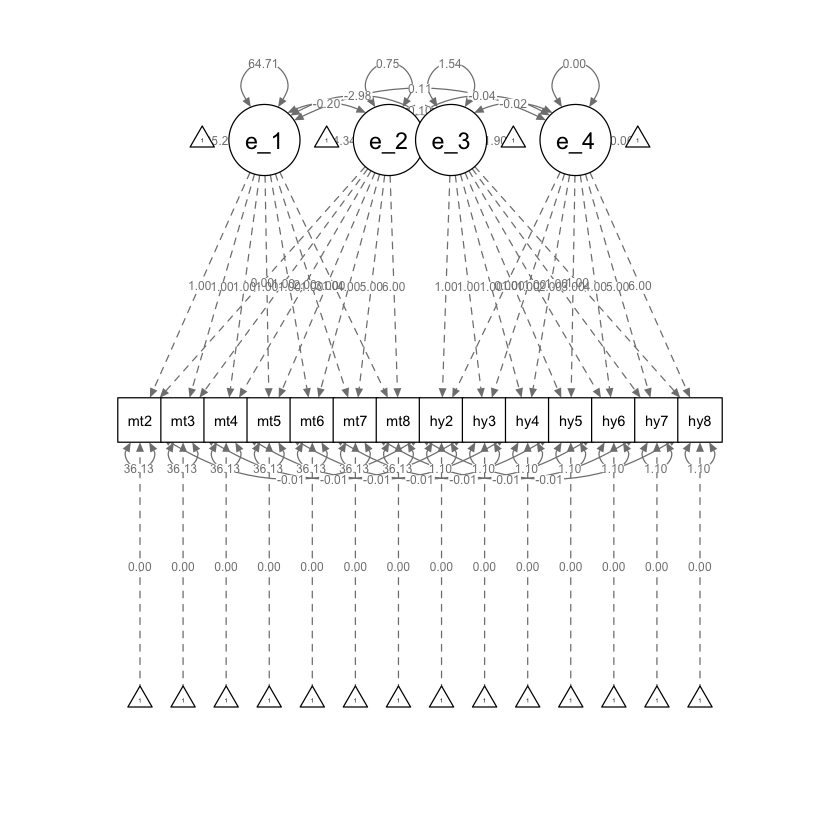

In [9]:
semPaths(bivariate_lavaan_fit, what = "path", whatLabels = "par")

## Conclusione

Questo tutorial ha presentato come il modello di crescita multivariato possa essere utilizzato per esaminare le interrelazioni nel cambiamento - in particolare la correlazione between-person tra le pendenze.